In [14]:
from tf2_bert.models import build_transformer_model
from tf2_bert.tokenizers import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Lambda,Dense,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from plot_model import plot_model

In [15]:
# 周期数
epochs = 5
# 批次大小
batch_size = 16
# 验证集占比
validation_split = 0.2
# 句子长度
seq_len = 256

In [17]:
# 载入数据
data = pd.read_excel('reviews.xlsx')

In [18]:
# 查看数据前5行
data.head()

,评论,性价比,产品质量,参加活动,客服物流包装,是否为老顾客,是否会再买,总体评论
0,这款面膜非常的好，真的，特别的水分充足，然后这个面膜材质非常的细腻，对皮肤很好，没有过敏，我...,1,1,0,0,0,0,1
1,面膜很好，挺滋润的，精华很多，买了好几次了，下次有活动再屯点吧！喜欢喜欢喜欢喜欢喜欢喜欢喜欢...,0,1,1,0,1,1,1
2,这款补水保湿的面膜收到货就用了，感觉还不错，吸收挺好，精华液也挺多的，贴完后按摩了一下，吸收...,0,1,0,0,0,0,1
3,美白效果：发觉皮肤越来越水润光泽，肤色也被提亮了，气色变得越来越好，敷上去感觉滑滑的。补水效...,0,1,0,0,-1,0,1
4,什么事也可以让我们变好吗、不会让别人看到别人和她们在背后议论自己喜欢你什么地方好玩不了自己了...,0,0,0,0,0,0,0


In [19]:
# 定义预训练模型路径
model_dir = './chinese_roberta_wwm_ext_L-12_H-768_A-12'
# BERT参数
config_path = model_dir+'/bert_config.json'
# 保存模型权值参数的文件
checkpoint_path = model_dir+'/bert_model.ckpt'
# 词表
dict_path = model_dir+'/vocab.txt'
# 建立分词器
tokenizer = Tokenizer(dict_path) 
# 建立模型，加载权重
bert_model = build_transformer_model(config_path, checkpoint_path) 

In [20]:
token_ids = []
segment_ids = []
# 循环每个句子
for s in data['评论'].astype(str):
    # 分词并把token变成编号
    token_id,segment_id = tokenizer.encode(s, first_length=seq_len)
    token_ids.append(token_id)
    segment_ids.append(segment_id)
token_ids = np.array(token_ids)
segment_ids = np.array(segment_ids)

In [21]:
label = []
# 定义标签
def LabelEncoder(y):
    # 增加一个维度
    y = y[:,np.newaxis]
    # 原始标签把-1,0,1变成0,1,2
    y = y+1
    y = y.astype('uint8')
    # 转成独热编码
    y = to_categorical(y, num_classes=3)
    return y

# 获取7个维度的标签，并把每个维度的标签从-1,0,1变成0,1,2
label = [(LabelEncoder(np.array(data[columns]))) for columns in data.columns[1:]]
label = np.array(label)
print(label.shape)

(7, 10000, 3)


In [22]:
# token输入
token_in = Input(shape=(None,))
# segment输入
segment_in = Input(shape=(None,))
# 使用BERT进行特征提取
x = bert_model([token_in, segment_in])
# 每个序列的第一个字符是句子的分类[CLS],该字符对应的embedding可以用作分类任务中该序列的总表示
# 说白了就是用句子第一个字符的embedding来表示整个句子
# 取出每个句子的第一个字符对应的embedding
x = Lambda(lambda x: x[:, 0])(x)

# 多任务学习
# 性价比输出层
x0 = Dropout(0.5)(x)
preds0 = Dense(3, activation='softmax',name='out0')(x0)

# 产品质量输出层
x1 = Dropout(0.5)(x)
preds1 = Dense(3, activation='softmax',name='out1')(x1)

# 参加活动输出层
x2 = Dropout(0.5)(x)
preds2 = Dense(3, activation='softmax',name='out2')(x2)

# 客服物流包装输出层
x3 = Dropout(0.5)(x)
preds3 = Dense(3, activation='softmax',name='out3')(x3)

# 是否为老顾客输出层
x4 = Dropout(0.5)(x)
preds4 = Dense(3, activation='softmax',name='out4')(x4)

# 是否会再买输出层
x5 = Dropout(0.5)(x)
preds5 = Dense(3, activation='softmax',name='out5')(x5)

# 总体评论输出层
x6 = Dropout(0.5)(x)
preds6 = Dense(3, activation='softmax',name='out6')(x6)

# 定义模型
model = Model([token_in, segment_in], [preds0,preds1,preds2,preds3,preds4,preds5,preds6])

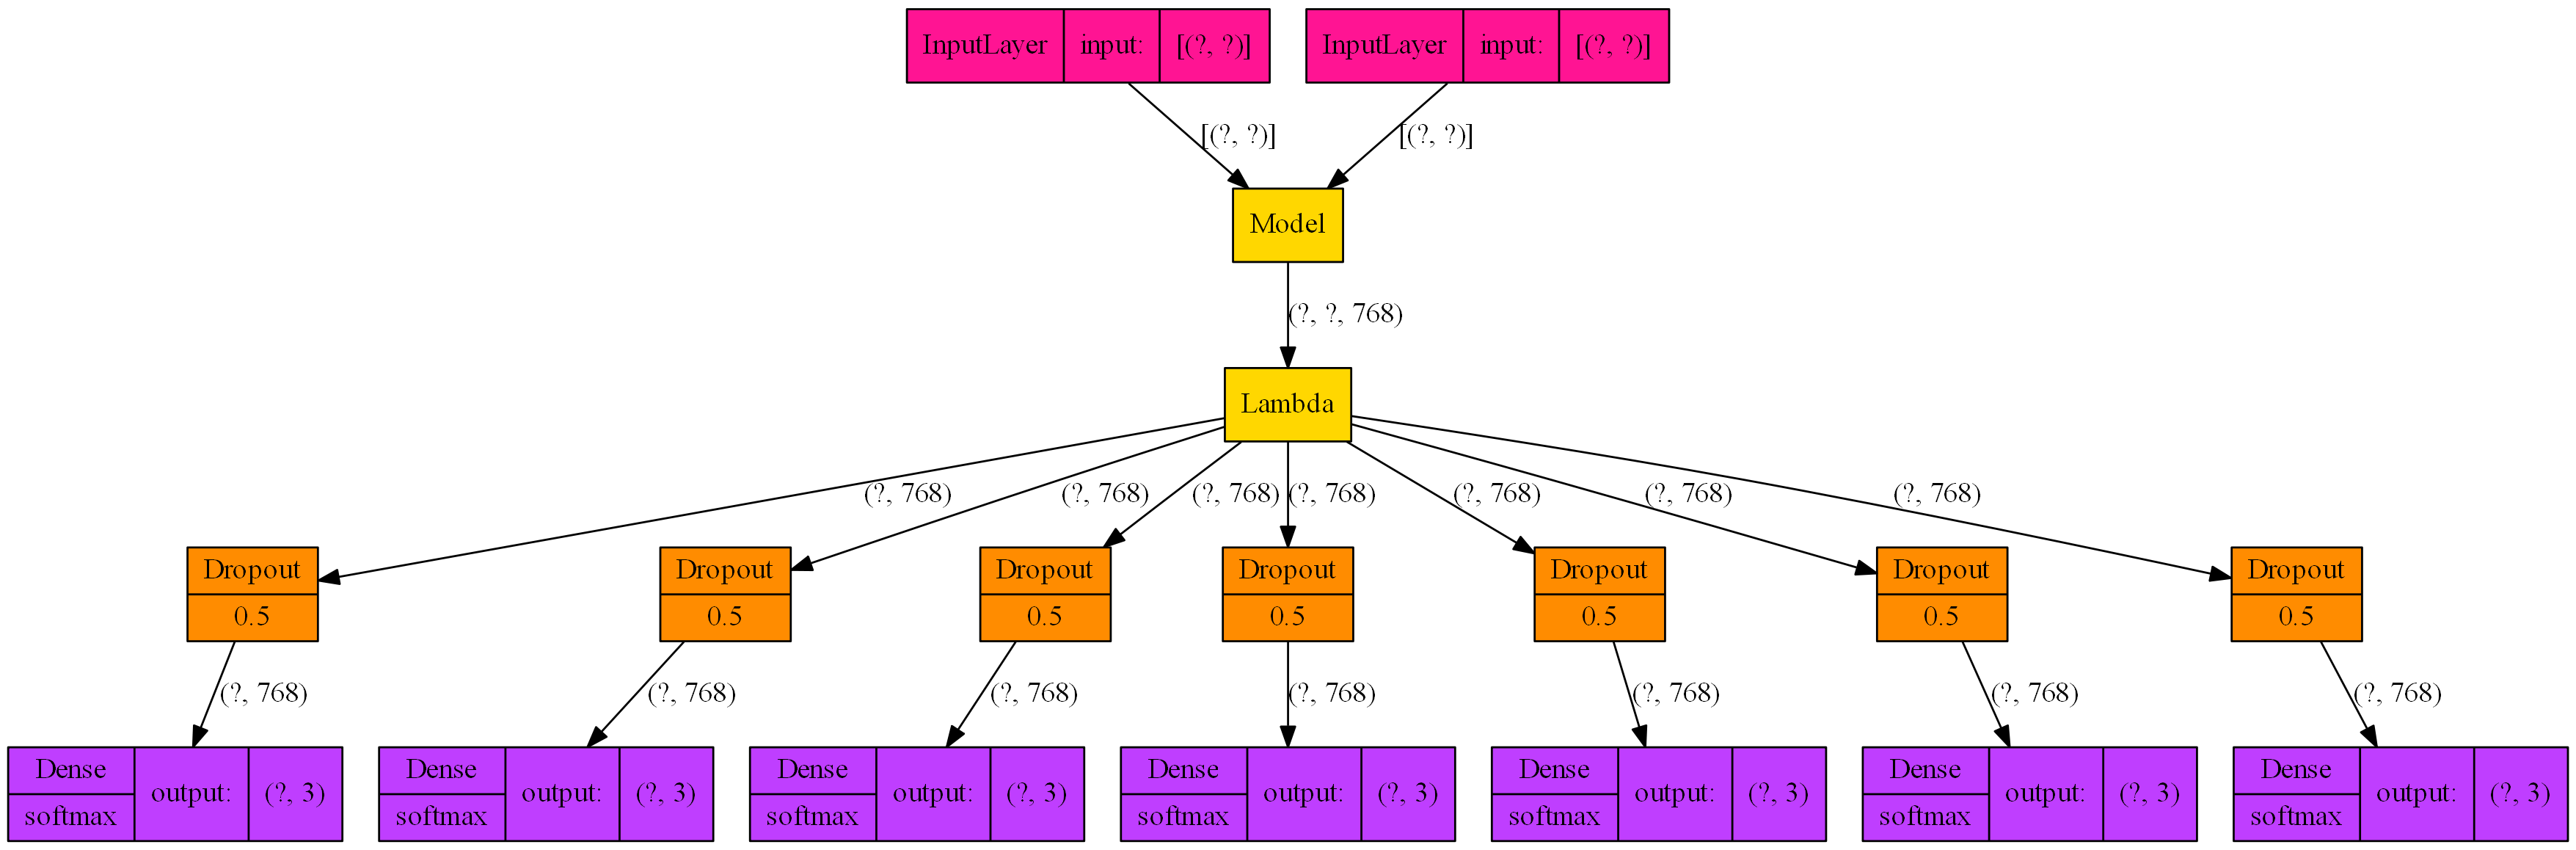

In [24]:
# 画出模型结构
plot_model(model,dpi=200)

In [13]:
# 定义模型训练的loss，loss_weights，optimizer
# loss_weights表示每个任务的权重，可以看情况设置
model.compile(loss={
                  'out0': 'categorical_crossentropy',
                  'out1': 'categorical_crossentropy',
                  'out2': 'categorical_crossentropy',
                  'out3': 'categorical_crossentropy',
                  'out4': 'categorical_crossentropy',
                  'out5': 'categorical_crossentropy',
                  'out6': 'categorical_crossentropy'},
                loss_weights={
                  'out0': 1.,
                  'out1': 1.,
                  'out2': 1.,
                  'out3': 1.,
                  'out4': 1.,
                  'out5': 1,
                  'out6': 2.},
                optimizer=Adam(1e-5),
                metrics=['accuracy'])

# 保存val_loss最低的模型
callbacks = [ModelCheckpoint(filepath='bert_model/'+'{epoch:02d}.h5',
                    monitor='val_loss',
                    verbose=1,
                    save_best_only=True)]

# 训练模型
model.fit([token_ids, segment_ids], [label[0],label[1],label[2],label[3],label[4],label[5],label[6]],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=validation_split,
          callbacks=callbacks)

Train on 8000 samples, validate on 2000 samples
Epoch 1/5
7984/8000 [============================>.] - ETA: 0s - loss: 3.4144 - out0_loss: 0.2809 - out1_loss: 0.6564 - out2_loss: 0.2141 - out3_loss: 0.4407 - out4_loss: 0.4736 - out5_loss: 0.2666 - out6_loss: 0.5410 - out0_accuracy: 0.9176 - out1_accuracy: 0.7325 - out2_accuracy: 0.9400 - out3_accuracy: 0.8403 - out4_accuracy: 0.8391 - out5_accuracy: 0.9163 - out6_accuracy: 0.8111
Epoch 00001: val_loss improved from inf to 2.99415, saving model to bert_model/01.h5
8000/8000 [==============================] - 295s 37ms/sample - loss: 3.4106 - out0_loss: 0.2808 - out1_loss: 0.6558 - out2_loss: 0.2136 - out3_loss: 0.4399 - out4_loss: 0.4729 - out5_loss: 0.2661 - out6_loss: 0.5407 - out0_accuracy: 0.9176 - out1_accuracy: 0.7329 - out2_accuracy: 0.9401 - out3_accuracy: 0.8406 - out4_accuracy: 0.8394 - out5_accuracy: 0.9165 - out6_accuracy: 0.8111 - val_loss: 2.9941 - val_out0_loss: 0.2515 - val_out1_loss: 0.5479 - val_out2_loss: 0.3026 - val